In [1]:
import json
import pickle
from bertopic import BERTopic

with open(r'C:\Users\leonc\Thesis 2024\Toxic-Symbology\Text Clustering\ontoxGPAHE.json', 'r') as f:
    data = json.load(f)

descriptions = [entry["Description"] for entry in data.values()]

In [2]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(descriptions, show_progress_bar=True)

Batches:   0%|          | 0/25 [00:00<?, ?it/s]

In [3]:
import umap
import pandas as pd
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

In [4]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

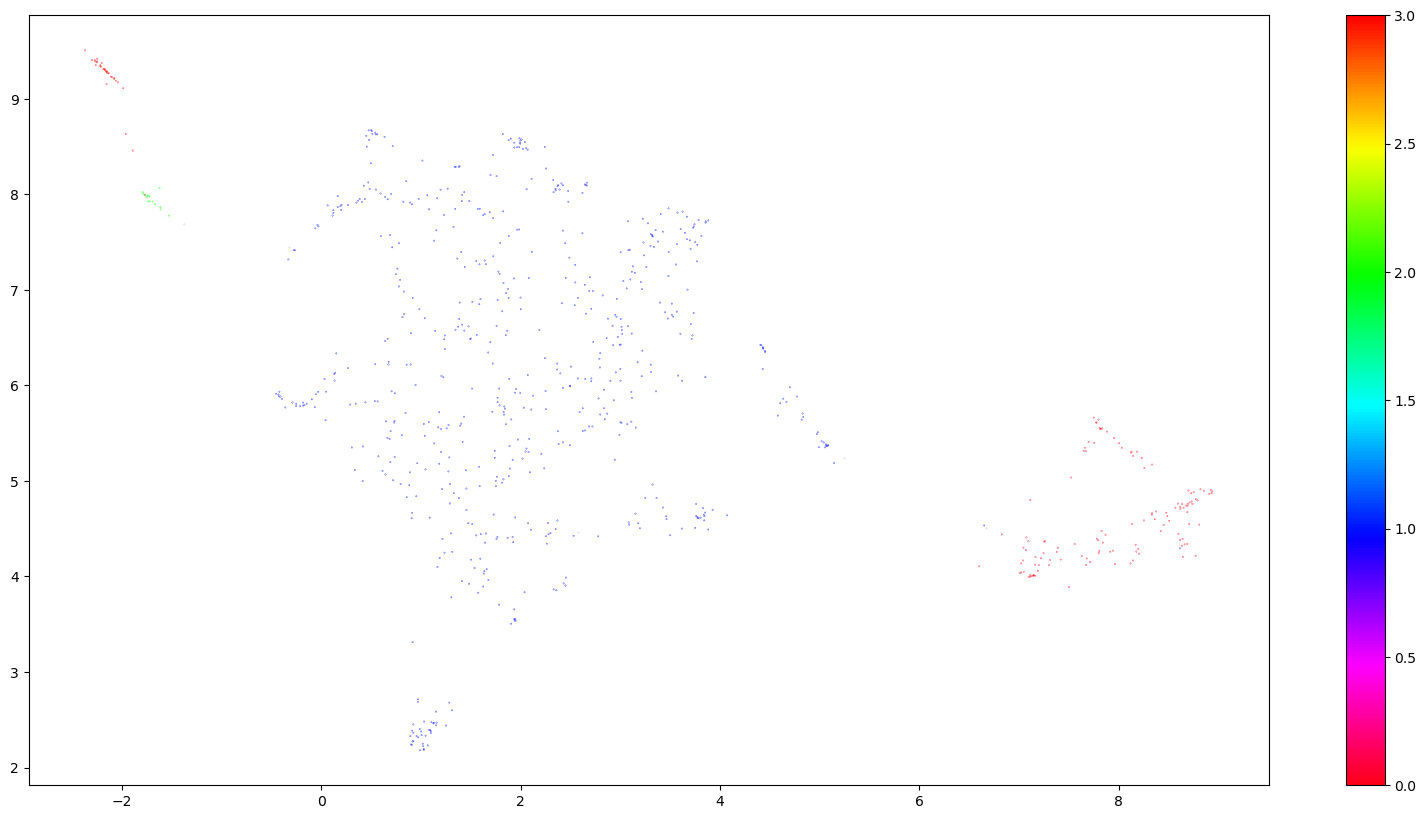

In [5]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [6]:
docs_df = pd.DataFrame(descriptions, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [7]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

In [8]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
2,1,620
1,0,126
4,3,32
3,2,15
0,-1,6


In [9]:
top_n_words[-1]

[('florida', 0.0565448390030744),
 ('nsf', 0.05641160259695116),
 ('hungária', 0.05641160259695116),
 ('légió', 0.05641160259695116),
 ('combat', 0.04240862925230581),
 ('templar', 0.04033813983303925),
 ('natsoc', 0.04033813983303925),
 ('ba', 0.04033813983303925),
 ('nunes', 0.04033813983303925),
 ('binary', 0.0376077350646341),
 ('focus', 0.03190202556707718),
 ('lgb', 0.03190202556707718),
 ('acronym', 0.031002824269942345),
 ('pride', 0.030209672514680506),
 ('communities', 0.030209672514680506),
 ('supremacy', 0.02950017409274228),
 ('transgender', 0.028858354700120565),
 ('trans', 0.028858354700120565),
 ('burgundy', 0.028858354700120565),
 ('fighting', 0.0282724195015372)]

In [10]:
with open('top_n_words.pkl', 'wb') as fp:
    pickle.dump(top_n_words, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


In [11]:
with open(r'C:\Users\leonc\Thesis 2024\Toxic-Symbology\Text Clustering\top_n_words.pkl', 'rb') as fp:
    top_n_words_dict = pickle.load(fp)
    print(top_n_words_dict)

{-1: [('florida', 0.0565448390030744), ('nsf', 0.05641160259695116), ('hungária', 0.05641160259695116), ('légió', 0.05641160259695116), ('combat', 0.04240862925230581), ('templar', 0.04033813983303925), ('natsoc', 0.04033813983303925), ('ba', 0.04033813983303925), ('nunes', 0.04033813983303925), ('binary', 0.0376077350646341), ('focus', 0.03190202556707718), ('lgb', 0.03190202556707718), ('acronym', 0.031002824269942345), ('pride', 0.030209672514680506), ('communities', 0.030209672514680506), ('supremacy', 0.02950017409274228), ('transgender', 0.028858354700120565), ('trans', 0.028858354700120565), ('burgundy', 0.028858354700120565), ('fighting', 0.0282724195015372)], 0: [('club', 0.03187157788363491), ('active', 0.030574054452191482), ('sports', 0.027122746715960905), ('clubs', 0.02693738018560956), ('rundo', 0.026313115314590137), ('robert', 0.02618512798819017), ('train', 0.026142933561690947), ('upcoming', 0.025968426503572527), ('oppressive', 0.025968426503572527), ('perceive', 0.